In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from matplotlib.cbook import boxplot_stats

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

loadedBase = pd.read_csv("drugMap_with_230_features.csv", sep="\t")
loadedBase = loadedBase.replace([np.inf, -np.inf], np.nan)

#### Reclassificação de moléculas

In [2]:
#Withdrwan from Market to Discontinued
withdrawnToDiscontinued = ["Phenacetin", "Astemizole", "FORMESTANE", "Zomepirac", "Ebrotidine", "Flupenthixol", "Ximelagatran", "Droxicam", "INDOPROFEN", "Cephaloridine", "Sertindole", "Indoramin", "Clioquinol", "Phenolphthalein", "Methaqualone", "Bithionol", "TBC 11251 (TBC)", "Benoxaprofen", "Dexfenfluramine", "Etilefrine", "Isoxicam", "Phenformin", "Fendiline", "LYSERGIC ACID DIETHYLAMIDE", "Aminopterin", "Remoxipride", "ZIMELIDINE", "Casopitant", "Ticrynafen", "Sitaxsentan", "Encainide", "Fencamfamine", "HEXESTROL", "Chlorotrianisene", "Terfenadine", "Phenylpropanolamine", "Roxithromycin", "Amineptine", "Temafloxacin", "Metamizole"]

loadedBase.loc[loadedBase.name.isin(withdrawnToDiscontinued), "status"] = "Discontinued"
#loadedBase[loadedBase.name.isin(withdrawnToDiscontinued)]


#Withdrwan from Market to Approved (Removida por motivos mercadológicos)
loadedBase.loc[loadedBase.name == "Alprenolol", "status"] = "Approved"
loadedBase.loc[loadedBase.name == "Bethanidine", "status"] = "Approved"
#loadedBase[loadedBase.name == "Alprenolol"]
#loadedBase[loadedBase.name == "Bethanidine"]


#Approval Submitted to Discontinued in Phase 3
loadedBase.loc[loadedBase.name == "RLX030", "status"] = "Discontinued in Phase 3"
#loadedBase[loadedBase.name == "RLX030"]


#Phase 4 to Discontinued
loadedBase.loc[loadedBase.name == "Glypromate", "status"] = "Discontinued"
loadedBase.loc[loadedBase.name == "Aminophenazone", "status"] = "Discontinued"
#loadedBase[loadedBase.name == "Glypromate"]
#loadedBase[loadedBase.name == "Aminophenazone"]


#Phase 4 to Phase 2
loadedBase.loc[loadedBase.name == "Dihydrotestosterone", "status"] = "Phase 2"
loadedBase.loc[loadedBase.name == "Guanoxan", "status"] = "Phase 2"
#loadedBase[loadedBase.name == "Dihydrotestosterone"]
#loadedBase[loadedBase.name == "Guanoxan"]

#### Funções Auxiliares

In [3]:
import pandas as pd
import numpy as np
import sys
from scipy.stats import spearmanr

def find_identical_features(df):
    identical_features = []
    seen_features = set()
    for col1 in df.columns:
        if col1 in seen_features:
            continue
        for col2 in df.columns:
            if col1 != col2 and df[col1].equals(df[col2]):
                identical_features.append((col1, col2))
                seen_features.add(col2)
    return identical_features

def find_highly_correlated_features(df):
    correlated_features = []
    if "Van der Waals Surface Area" in df.columns:
        df_clean = df.drop(["Van der Waals Surface Area"], axis=1)
        df_clean = df_clean.dropna()
    else:
        df_clean = df.dropna()
    
    # Iterate over each pair of features and calculate Spearman correlation
    for i, col1 in enumerate(df_clean.columns):
        for j, col2 in enumerate(df_clean.columns):
            if i < j:
                corr, _ = spearmanr(df_clean[col1], df_clean[col2])
                if corr > 0.9:
                    correlated_features.append((col1, col2, corr))
    return correlated_features

def create_reduced_dataframe(df, identical_features, correlated_features):
    # Keep track of features to remove
    features_to_remove = set()

    # For identical features, keep only the first occurrence
    for feature1, feature2 in identical_features:
        features_to_remove.add(feature2)  # Remove duplicates, keep feature1

    # For correlated features, choose to keep the first feature and remove the second
    for feature1, feature2, _ in correlated_features:
        if feature2 not in features_to_remove:  # Avoid removing twice
            features_to_remove.add(feature2)

    # Create a reduced dataframe by dropping the redundant features
    reduced_df = df.drop(columns=features_to_remove)
    return reduced_df

def remove_print_process(df):

    # Identify identical and highly correlated features
    identical_features = find_identical_features(df)
    correlated_features = find_highly_correlated_features(df)

    # Print identical features
    print("\nIdentical Features:")
    if identical_features:
        for feature1, feature2 in identical_features:
            print(f"Identical: {feature1} and {feature2}")
    else:
        print("No identical features found.")

    # Print highly correlated features
    print("\nHighly Correlated Features (Spearman > 0.9):")
    if correlated_features:
        for feature1, feature2, corr in correlated_features:
            print(f"Correlated: {feature1} and {feature2} with correlation {corr:.2f}")
    else:
        print("No highly correlated features found.")

    # Create reduced dataframe
    reduced_df = create_reduced_dataframe(df, identical_features, correlated_features)

    return reduced_df

In [4]:
#Remover instâncias com classes de não interesse e binarizar base
#A binarização da base segue a sugestão de tiago alterando apenas sobre withdrawn from market

def binarizar_base (df):

    filertedDf = df[
        (df.status == "Approved") | 
        (df.status == "Approved (orphan drug)") | 
        (df.status == "Approval submitted") | 
        (df.status == "Phase 4") | 
        (df.status == "Discontinued") | 
        (df.status == "Discontinued in Phase 1") | 
        (df.status == "Discontinued in Phase 1/2") | 
        (df.status == "Discontinued in Phase 2") | 
        (df.status == "Discontinued in Phase 2a") |
        (df.status == "Discontinued in Phase 2b") | 
        (df.status == "Discontinued in Phase 2/3") | 
        (df.status == "Discontinued in Phase 3") | 
        (df.status == "Discontinued in Phase 4") |
        (df.status == "Discontinued in Preregistration") |
        (df.status == "Terminated")
    ].copy()

    filertedDf.replace("Approved", 1.0, inplace=True)
    filertedDf.replace("Approved (orphan drug)", 1.0, inplace=True)
    filertedDf.replace("Approval submitted", 1.0, inplace=True)
    filertedDf.replace("Phase 4", 1.0, inplace=True)

    filertedDf.replace("Discontinued", 0.0, inplace=True)
    filertedDf.replace("Discontinued in Phase 1", 0.0, inplace=True)
    filertedDf.replace("Discontinued in Phase 1/2", 0.0, inplace=True)
    filertedDf.replace("Discontinued in Phase 2", 0.0, inplace=True)
    filertedDf.replace("Discontinued in Phase 2a", 0.0, inplace=True)
    filertedDf.replace("Discontinued in Phase 2b", 0.0, inplace=True)
    filertedDf.replace("Discontinued in Phase 2/3", 0.0, inplace=True)
    filertedDf.replace("Discontinued in Phase 3", 0.0, inplace=True)
    filertedDf.replace("Discontinued in Phase 4", 0.0, inplace=True)
    filertedDf.replace("Discontinued in Preregistration", 0.0, inplace=True)
    filertedDf.replace("Terminated", 0.0, inplace=True)

    return filertedDf


#### Versão controle do pré-processamento

In [5]:
base = loadedBase

In [6]:
base.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22527 entries, 0 to 22526
Data columns (total 233 columns):
 #    Column                                  Non-Null Count  Dtype  
---   ------                                  --------------  -----  
 0    name                                    22527 non-null  object 
 1    SMILES                                  22527 non-null  object 
 2    Molecular Weight                        22527 non-null  float64
 3    LogP                                    22527 non-null  float64
 4    TPSA                                    22527 non-null  float64
 5    Number of Rotatable Bonds               22527 non-null  int64  
 6    Number of H-Bond Donors                 22527 non-null  int64  
 7    Number of H-Bond Acceptors              22527 non-null  int64  
 8    Number of Aromatic Rings                22527 non-null  int64  
 9    Number of Aliphatic Rings               22527 non-null  int64  
 10   Number of Heavy Atoms                   2252

In [72]:
#Vizualização da correlação 
temp = base.drop(["name", "SMILES", "status"], axis=1).copy()
temp.corr()

,Molecular Weight,LogP,TPSA,Number of Rotatable Bonds,Number of H-Bond Donors,Number of H-Bond Acceptors,Number of Aromatic Rings,Number of Aliphatic Rings,Number of Heavy Atoms,Molar Refractivity,Fraction of Csp3 Carbons,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Chi2,Solvent Accessible Surface Area (SASA),Principal Moment of Inertia 1,Principal Moment of Inertia 2,Principal Moment of Inertia 3,Radius of Gyration,Asphericity,Van der Waals Surface Area,MMFF Energy,UFF Energy
Molecular Weight,1.000000,-0.185952,0.882576,0.823721,0.814909,0.860471,0.383391,0.330421,0.992161,0.983525,0.140736,0.411577,0.411577,-0.253329,-0.266369,-0.550310,0.170616,1.000000,0.999506,0.999999,0.992567,0.029157,0.181457,-0.183276,0.145008,0.243035,-0.452084,-0.420524,-0.341576,0.100437,-0.069066,0.380604,-0.353939,0.243642,-0.418554,0.205527,-0.280936,0.307289,-0.353362,0.951121,0.983501,0.983501,0.992543,0.972458,0.972458,0.985942,0.954008,0.968368,0.908816,0.932525,...,0.023596,-0.010267,0.148361,-0.002017,-0.012123,-0.005597,0.010969,0.010902,0.014668,0.084007,0.082293,0.010779,-0.023034,-0.016234,-0.010803,-0.007693,-0.019100,-0.008518,0.011230,0.079342,0.162987,0.163839,0.063276,0.064768,0.036143,0.045775,0.512854,NaN,-0.002275,0.023366,0.103482,0.037102,0.014093,-0.021390,0.025906,0.022716,-0.004659,-0.001831,0.164755,0.048512,0.954008,0.973649,0.700571,0.720953,0.717642,0.781718,-0.050623,NaN,0.467109,0.008657
LogP,-0.185952,1.000000,-0.546020,-0.164294,-0.508964,-0.468662,0.302724,-0.013858,-0.153949,-0.081883,-0.178334,-0.000003,-0.000003,-0.011961,0.180670,0.105076,-0.136923,-0.185952,-0.191474,-0.186210,-0.175682,-0.103179,-0.179532,0.109598,-0.158611,-0.190744,-0.198157,-0.065600,0.062211,0.021665,-0.087518,-0.022122,-0.101389,0.266375,0.198504,-0.057486,0.080110,0.301008,-0.150514,-0.114414,-0.120635,-0.120635,-0.149086,-0.081783,-0.081783,-0.125795,-0.064259,-0.111456,-0.015735,-0.067548,...,-0.013856,-0.009847,-0.109004,-0.031701,-0.009128,0.002735,0.061357,0.055341,-0.072186,0.010051,0.099652,-0.000264,0.032531,0.000294,0.007430,0.006772,-0.007288,0.049999,-0.010545,0.080335,-0.016871,-0.018400,-0.185833,-0.173455,0.082832,0.033243,-0.304573,NaN,0.132286,-0.027479,-0.049429,-0.007851,0.011049,-0.014059,0.000483,0.045361,-0.004756,0.053919,0.103177,0.041364,-0.064259,-0.141944,-0.264954,-0.230713,-0.233026,0.123244,0.129980,NaN,-0.083177,0.014863
TPSA,0.882576,-0.546020,1.000000,0.759868,0.941234,0.916866,0.193941,0.201788,0.870667,0.830539,0.150430,0.346912,0.346912,-0.207836,-0.312077,-0.525767,0.148480,0.882576,0.884693,0.882745,0.880891,0.065569,0.209350,-0.181821,0.151276,0.284489,-0.280431,-0.314131,-0.308506,0.018487,-0.019616,0.283294,-0.175787,0.084899,-0.336323,0.167954,-0.242611,0.101743,-0.137736,0.829177,0.843658,0.843658,0.853564,0.816773,0.816773,0.844289,0.789181,0.818505,0.720600,0.761174,...,0.024540,-0.002735,0.183416,0.005823,-0.004788,-0.004266,-0.006532,-0.007666,0.033496,0.064472,0.001324,-0.022830,-0.011200,0.030606,0.028024,0.024287,-0.002573,-0.012364,0.015044,0.024735,0.211082,0.211204,0.1

In [73]:
#Drop de atributo sem valor para todas as instâncias
base.drop(["Van der Waals Surface Area"], axis=1, inplace=True)

In [7]:
base = remove_print_process(base)

C:\Users\felip\AppData\Local\Temp\ipykernel_33032\3338146763.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(df_clean[col1], df_clean[col2])



Identical Features:
Identical: Molecular Weight and MolWt
Identical: LogP and MolLogP
Identical: Number of Rotatable Bonds and NumRotatableBonds
Identical: Number of H-Bond Donors and NumHDonors
Identical: Number of H-Bond Acceptors and NumHAcceptors
Identical: Number of Aromatic Rings and NumAromaticRings
Identical: Number of Aliphatic Rings and NumAliphaticRings
Identical: Number of Heavy Atoms and HeavyAtomCount
Identical: Molar Refractivity and MolMR
Identical: Fraction of Csp3 Carbons and FractionCSP3
Identical: MaxAbsEStateIndex and MaxEStateIndex
Identical: Chi0 and Chi0n
Identical: Chi1 and Chi1n
Identical: Chi2n and Chi2
Identical: SMR_VSA8 and SlogP_VSA9
Identical: fr_Ar_NH and fr_Nhpyrrole

Highly Correlated Features (Spearman > 0.9):
Correlated: Molecular Weight and Number of Heavy Atoms with correlation 0.98
Correlated: Molecular Weight and Molar Refractivity with correlation 0.96
Correlated: Molecular Weight and MolWt with correlation 1.00
Correlated: Molecular Weight an

In [8]:
base.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22527 entries, 0 to 22526
Data columns (total 174 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    name                        22527 non-null  object 
 1    SMILES                      22527 non-null  object 
 2    Molecular Weight            22527 non-null  float64
 3    LogP                        22527 non-null  float64
 4    TPSA                        22527 non-null  float64
 5    Number of Rotatable Bonds   22527 non-null  int64  
 6    Number of H-Bond Donors     22527 non-null  int64  
 7    Number of H-Bond Acceptors  22527 non-null  int64  
 8    Number of Aromatic Rings    22527 non-null  int64  
 9    Number of Aliphatic Rings   22527 non-null  int64  
 10   Fraction of Csp3 Carbons    22527 non-null  float64
 11   MaxAbsEStateIndex           22527 non-null  float64
 12   MinAbsEStateIndex           22527 non-null  float64
 13   MinEStateIndex

In [76]:
base.status.value_counts()

status
Investigative                      13830
Patented                            2125
Approved                            1950
Phase 2                             1089
Terminated                           762
Phase 1                              655
Discontinued in Phase 2              555
Phase 3                              467
Discontinued in Phase 1              310
Preclinical                          239
Discontinued in Phase 3              137
Phase 1/2                            137
Phase 4                               79
Phase 2/3                             57
Discontinued                          43
Clinical trial                        31
Discontinued in Preregistration       22
Discontinued in Phase 1/2             11
Phase 2a                               6
Withdrawn from market                  4
Registered                             4
Approved (orphan drug)                 2
Discontinued in Phase 4                2
Phase 2b                               2
Phase 1b 

In [77]:
base = binarizar_base(base)

C:\Users\felip\AppData\Local\Temp\ipykernel_20564\2232719908.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filertedDf.replace("Terminated", 0.0, inplace=True)


status
1.0    2031
0.0    1845
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

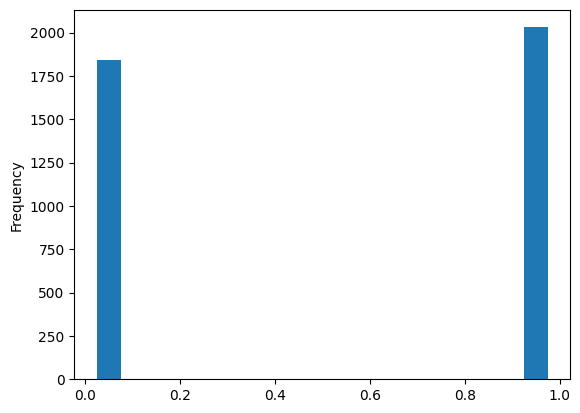

In [78]:
print(base.status.value_counts())
base['status'].plot.hist(rwidth=0.5)


In [79]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3876 entries, 0 to 8696
Columns: 173 entries, name to status
dtypes: float64(83), int64(88), object(2)
memory usage: 5.1+ MB


In [56]:
#Análise buscando por valores NaN
print(base.isnull().sum().sort_values(ascending=False))

MMFF Energy       200
BCUT2D_LOGPLOW    112
BCUT2D_MRLOW      112
BCUT2D_MRHI       112
BCUT2D_LOGPHI     112
                 ... 
EState_VSA1         0
EState_VSA10        0
EState_VSA11        0
EState_VSA2         0
status              0
Length: 173, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Index: 287 entries, 2 to 8672
Columns: 173 entries, name to status
dtypes: float64(83), int64(88), object(2)
memory usage: 390.1+ KB
status
0.0    170
1.0    117
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

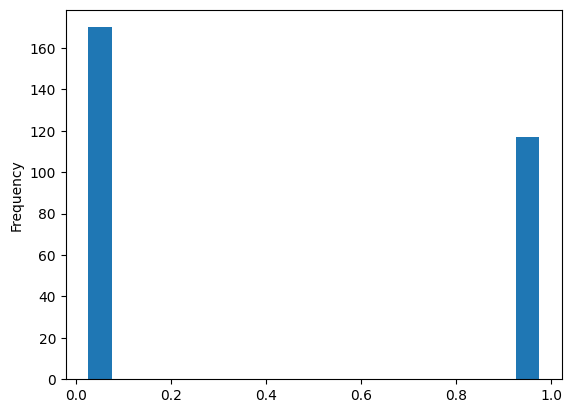

In [57]:
#Análise das instâncias com valores nulos para os atributos
df1 = base[base.isna().any(axis=1)]
df1.info()

print(df1.status.value_counts())
df1['status'].plot.hist(rwidth=0.5)

In [58]:
#Remoção de valores NaN
base.dropna(inplace=True)
base.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3589 entries, 0 to 8696
Data columns (total 173 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    name                        3589 non-null   object 
 1    SMILES                      3589 non-null   object 
 2    Molecular Weight            3589 non-null   float64
 3    LogP                        3589 non-null   float64
 4    TPSA                        3589 non-null   float64
 5    Number of Rotatable Bonds   3589 non-null   int64  
 6    Number of H-Bond Donors     3589 non-null   int64  
 7    Number of H-Bond Acceptors  3589 non-null   int64  
 8    Number of Aromatic Rings    3589 non-null   int64  
 9    Number of Aliphatic Rings   3589 non-null   int64  
 10   Fraction of Csp3 Carbons    3589 non-null   float64
 11   MaxAbsEStateIndex           3589 non-null   float64
 12   MinAbsEStateIndex           3589 non-null   float64
 13   MinEStateIndex       

In [80]:
base.drop(["SMILES", "name"], axis=1, inplace=True)

Features: 0 - 25
Axes(0.125,0.11;0.775x0.77)


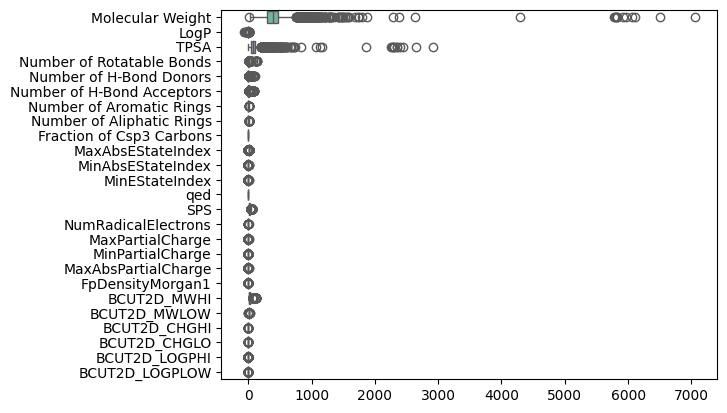

Features: 25 - 50
Axes(0.125,0.11;0.775x0.77)


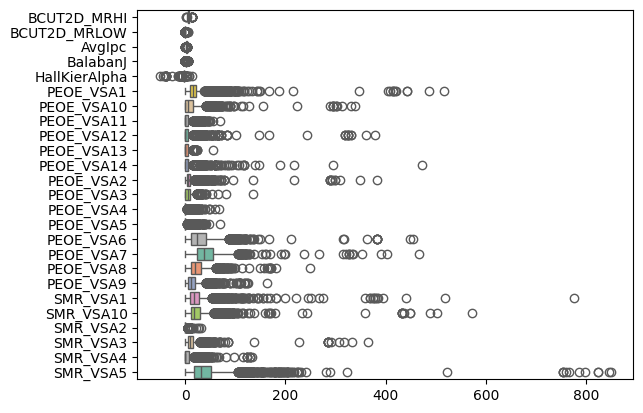

Features: 50 - 75
Axes(0.125,0.11;0.775x0.77)


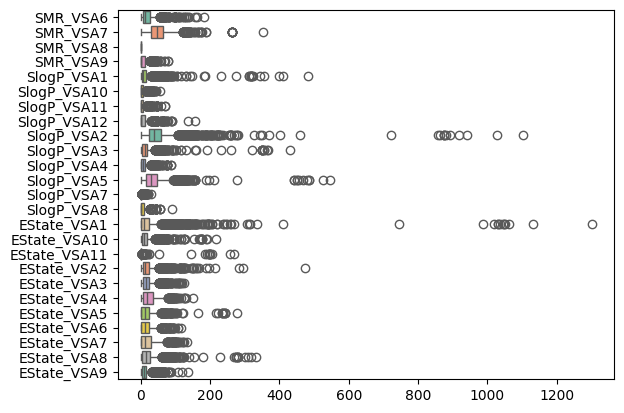

Features: 75 - 100
Axes(0.125,0.11;0.775x0.77)


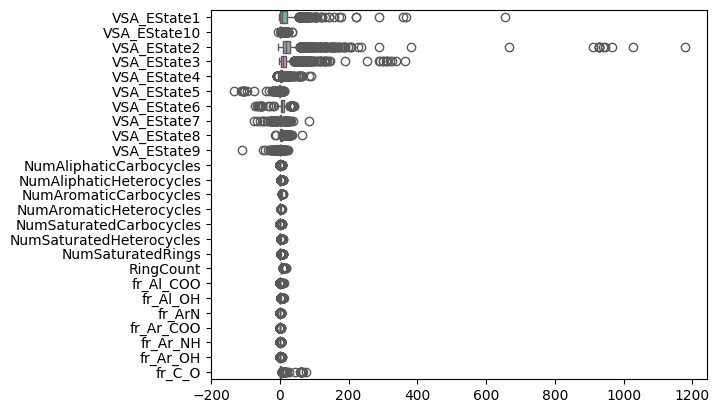

Features: 100 - 125
Axes(0.125,0.11;0.775x0.77)


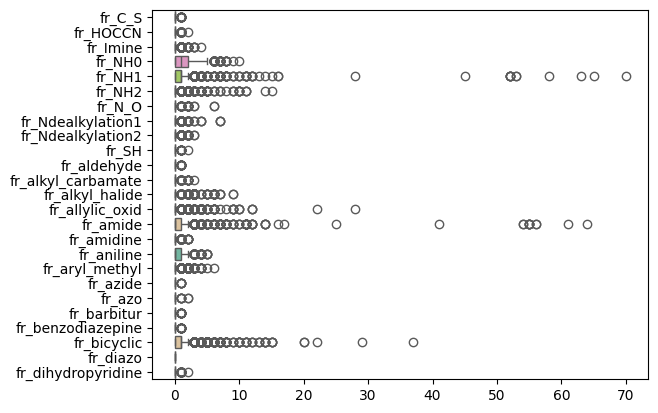

Features: 125 - 150
Axes(0.125,0.11;0.775x0.77)


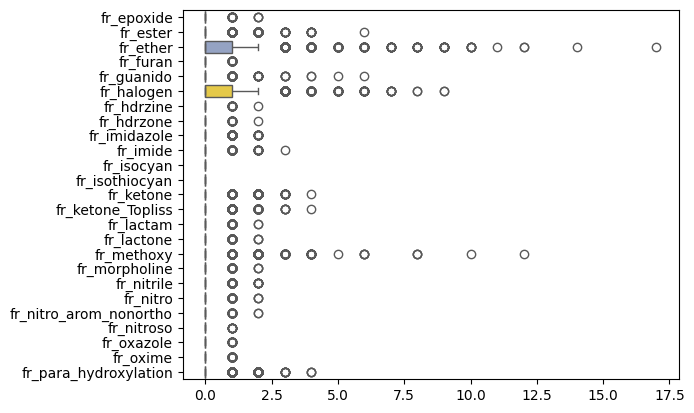

Features: 150 - 171
Axes(0.125,0.11;0.775x0.77)


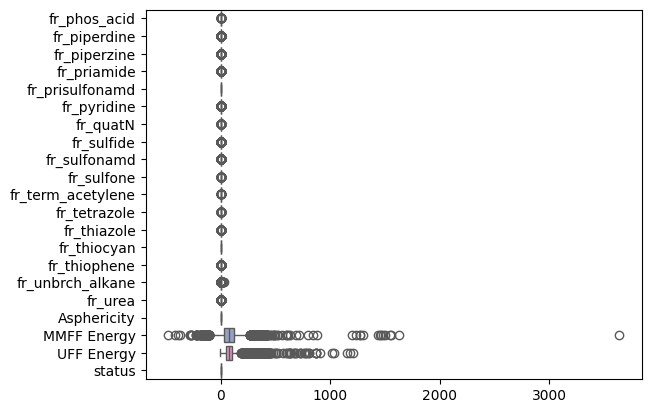

In [81]:
#Entender a distribuição de valores e a necessidade de normalização - Intervalos de 25 features
for i in range (len(base.columns)//25):
    print(f"Features: {25*i} - {25*(i+1)}")
    plt.figure()
    print(sns.boxplot(data=base.iloc[:, 25*i:25*(i+1)], orient="h", palette="Set2"))
    plt.show()

print(f"Features: {25*(i+1)} - {25*(i+1)+(len(base.columns))%25}")
plt.figure()
print(sns.boxplot(data=base.iloc[:, 25*(i+1):25*(i+1)+(len(base.columns))%25], orient="h", palette="Set2"))
plt.show()

In [82]:
#Duplicate analysis
temp = base.drop(["status"], axis=1).copy()
duplicated_values = temp.duplicated()
print(duplicated_values.sum())

0


In [83]:
#Remoção de duplicatas
subset = base.columns
subset = list(subset)
subset.remove("status")

base.drop_duplicates(subset=subset, keep='first', inplace=True)

In [84]:
#Duplicate analysis
temp = base.drop(["status"], axis=1).copy()
duplicated_values = temp.duplicated()
print(duplicated_values.sum())

0


status
1.0    2031
0.0    1845
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

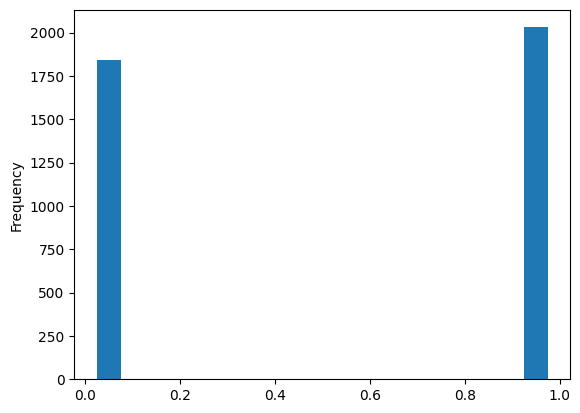

In [85]:
#Análise final de balanceamento
print(base.status.value_counts())
base['status'].plot.hist(rwidth=0.5)

In [86]:
base.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3876 entries, 0 to 8696
Data columns (total 171 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    Molecular Weight            3876 non-null   float64
 1    LogP                        3876 non-null   float64
 2    TPSA                        3876 non-null   float64
 3    Number of Rotatable Bonds   3876 non-null   int64  
 4    Number of H-Bond Donors     3876 non-null   int64  
 5    Number of H-Bond Acceptors  3876 non-null   int64  
 6    Number of Aromatic Rings    3876 non-null   int64  
 7    Number of Aliphatic Rings   3876 non-null   int64  
 8    Fraction of Csp3 Carbons    3876 non-null   float64
 9    MaxAbsEStateIndex           3876 non-null   float64
 10   MinAbsEStateIndex           3876 non-null   float64
 11   MinEStateIndex              3876 non-null   float64
 12   qed                         3876 non-null   float64
 13   SPS                  

In [30]:
base.to_csv("basePreProcessedAllAbFinal.csv", index=False)

#### Versão do pré-processamento com NaN

In [ ]:
base = loadedBase

In [ ]:
base.info(show_counts=True, verbose=True)

In [ ]:
#Drop de atributo sem valor para todas as instâncias
base.drop(["Van der Waals Surface Area"], axis=1, inplace=True)

In [ ]:
base = remove_print_process(base)

In [ ]:
print(base.status.value_counts())
base['status'].plot.hist(rwidth=0.5)

In [ ]:
#Análise buscando por valores NaN
print(base.isnull().sum().sort_values(ascending=False))

In [ ]:
#Análise das instâncias com valores nulos para os atributos
df1 = base[base.isna().any(axis=1)]
df1.info()

print(df1.status.value_counts())
df1['status'].plot.hist(rwidth=0.5)

In [ ]:
base.drop(["SMILES", "name"], axis=1, inplace=True)

In [ ]:
#Entender a distribuição de valores e a necessidade de normalização - Intervalos de 25 features
for i in range (len(base.columns)//25):
    print(f"Features: {25*i} - {25*(i+1)}")
    plt.figure()
    print(sns.boxplot(data=base.iloc[:, 25*i:25*(i+1)], orient="h", palette="Set2"))
    plt.show()

print(f"Features: {25*(i+1)} - {25*(i+1)+(len(base.columns))%25}")
plt.figure()
print(sns.boxplot(data=base.iloc[:, 25*(i+1):25*(i+1)+(len(base.columns))%25], orient="h", palette="Set2"))
plt.show()

In [ ]:
#Duplicate analysis
temp = base.drop(["status"], axis=1).copy()
duplicated_values = temp.duplicated()
print(duplicated_values.sum())

In [ ]:
#Remoção de duplicatas
subset = base.columns
subset = list(subset)
subset.remove("status")

base.drop_duplicates(subset=subset, keep='first', inplace=True)

In [ ]:
#Duplicate analysis
temp = base.drop(["status"], axis=1).copy()
duplicated_values = temp.duplicated()
print(duplicated_values.sum())

In [ ]:
#Análise final de balanceamento
print(base.status.value_counts())
base['status'].plot.hist(rwidth=0.5)

In [ ]:
base.info(show_counts=True, verbose=True)

In [ ]:
base.to_csv("basePreProcessedAllAbFinal_com_NaN.csv", index=False)